First, we need to clean up the data in the ZHVI dataset. This means removing redundant/unnecessary columns as well as locating the columns and rows where values are NaN. 

In [1]:
import pandas as pd
import numpy as np
#ZHVI Dataset
zhvi_df = pd.read_csv("sd_zhvi_2000_to_2025_nhbd.csv")
zhvi_df.drop(['RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], axis=1, inplace=True)


In [15]:
zhvi_df.head()

,RegionID,SizeRank,RegionName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
0,116625,90,Mira Mesa,193881.7585,194840.0815,195903.4942,198352.4132,200938.8613,204180.0619,207701.5108,...,1046746.397,1051713.196,1054413.072,1057080.913,1057115.586,1056057.281,1054485.277,1052457.096,1050504.472,1046568.637
1,117557,187,Rancho Penasquitos,276300.6498,277465.6004,278785.8929,281830.0231,285119.0125,289549.6017,294547.4396,...,1450380.875,1458144.232,1459419.574,1460119.166,1457301.759,1454203.141,1450405.007,1448253.763,1448123.563,1445833.232
2,273140,204,Carmel Valley,378712.6201,380143.9748,381913.8558,385808.6038,390122.3678,395477.2991,401717.6938,...,1943494.554,1947691.501,1947646.537,1949456.924,1953104.658,1959503.760,1968405.118,1977300.502,1987320.717,1994149.151
3,118673,207,University City,240596.5743,241378.2108,242623.4635,245345.9527,248520.5426,252322.8539,256613.3426,...,1042178.257,1044426.072,1043920.893,1043090.010,1040771.071,1038827.183,1037928.809,1037081.718,1038156.197,1037566.337
4,275127,253,Rancho Bernardo,227516.4417,228299.6955,229173.7764,231434.1174,233961.9119,237313.1689,241015.7291,...,1020552.731,1024780.848,1025505.028,1025162.413,1023944.381,1024404.047,1026352.719,1028927.961,1030551.993,1028547.286


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

Now, I do a cursory look at the ZHVI across the neighborhoods through a scatterplot across time within a year for every year. This is to look visibly at whether seasonal trends impact the housing market in some way.

In [ ]:
def seasonal_check(year):
    month_columns = [col for col in zhvi_df.columns if year in col]
    zhvi2000_long = zhvi_df[month_columns].melt(var_name='Month', value_name='Price')
    zhvi2000_long['Month'] = pd.to_datetime(zhvi2000_long['Month'], format='%Y-%m-%d')

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=zhvi2000_long, x='Month', y='Price', alpha=0.4, color='gray')
    sns.lineplot(data=zhvi2000_long, x='Month', y='Price', errorbar=None, estimator='mean', color='blue', label='Average Trend')

    plt.title('House Prices in All Neighborhoods (2000)')
    plt.xlabel('Month')
    plt.ylabel('House Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

i = 2000
while i <= 2025:
    seasonal_check(str(i))
    i=i+1

It does not appear that seasonal trends contributes to ZHVI variation. However, in order to statistically prove this to continue with our project, we will conduct a two-way ANOVA with the effect of month (seasonal) on ZHVI and the effect of year (overall) on ZHVI. We have to note that some neighborhoods only had ZHVI data from a particular point in time. In addition, some neighborhoods have missing values erratically. 

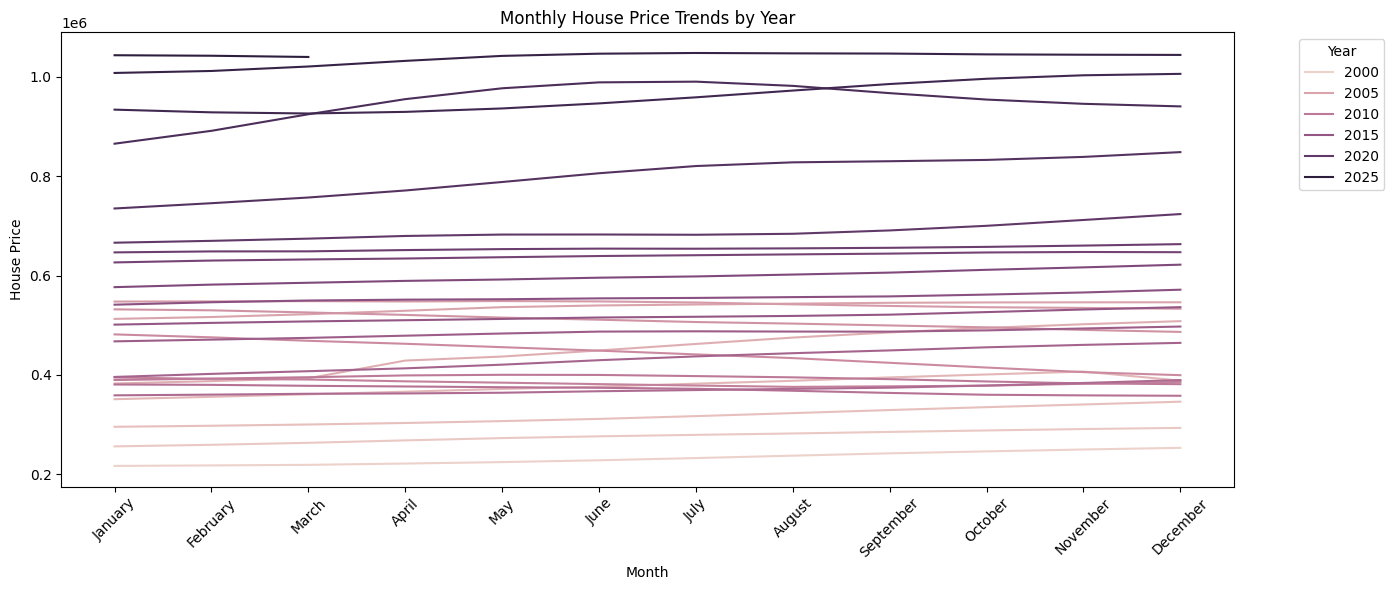

In [34]:
df_anova = zhvi_df[zhvi_df['2000-01-31'].notnull()]
df_anova = df_anova.melt(var_name='Date', value_name='Price', value_vars=zhvi_df.columns.difference(['RegionID', 'SizeRank', 'RegionName']))
df_anova['Date'] = pd.to_datetime(df_anova['Date'], format='%Y-%m-%d')
df_anova['Year'] = df_anova['Date'].dt.year
df_anova['Month'] = df_anova['Date'].dt.month_name()
df_anova['Month'] = pd.Categorical(df_anova['Month'], categories=['January', 'February', 'March','April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df_anova = df_anova.dropna(subset=['Price'])
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_anova, x='Month', y='Price', hue='Year', errorbar=None, estimator='mean')

plt.title('Monthly House Price Trends by Year')
plt.xlabel('Month')
plt.ylabel('House Price')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Now we will conduct an ANOVA using statsmodels.

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('Price ~ C(Month) + C(Year)', df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(Month),2.836724e+12,11.0,3.595552,0.000043
C(Year),1.359026e+15,25.0,757.929941,0.000000
Residual,2.145093e+15,29908.0,NaN,NaN


This model tells us that while Year explains most of the variance in house prices (showing that overall price level of houses drive changes in ZHVI), there is a small but statistically significant amount (p < 0.05) explained by Month. This shows that the ZHVI Index (despite being smoothed, but not specifically to San Diego) still has some level of its variance explained by month-based changes.

This is important because if we are to use these datapoints to explain the effect of transit on data, we must be aware that such changes could confound the effect of transit if not accounted for and rectified.